# Free Choice (FC) Trials Noise Analysis

This notebook analyzes noise characteristics in Free Choice (FC) trials compared to Instruction trials.
We'll examine various noise metrics including:
- Signal-to-noise ratio (SNR)
- Power spectral density variations
- Amplitude variability
- Baseline noise levels
- Artifact detection metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy.signal import butter, filtfilt, hilbert, welch
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, wilcoxon
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [142]:
# Load the raw EEG data
data_path = Path('../data/raw/05_25')

trials_dataset = np.load(data_path / 'trials_dataset.npy')
subjects_through_trials = np.load(data_path / 'subjects_through_trials.npy')
true_labels = np.load(data_path / 'true_labels.npy')
cues = np.load(data_path / 'cues.npy')
primes = np.load(data_path / 'primes.npy')
electrodes_names = np.load(data_path / 'electrodes_names.npy')

print(f"Data shape: {trials_dataset.shape}")
print(f"Number of electrodes: {len(electrodes_names)}")
print(f"Number of trials: {trials_dataset.shape[1]}")
print(f"Time points: {trials_dataset.shape[2]}")
print(f"Unique cues: {np.unique(cues)}")
print(f"Unique labels: {np.unique(true_labels)}")

Data shape: (64, 61415, 103)
Number of electrodes: 64
Number of trials: 61415
Time points: 103
Unique cues: [1. 2. 4.]
Unique labels: [1. 2.]


## Data Preprocessing and Trial Classification

In [ ]:
# Create masks for different trial types
unique_cues = np.unique(cues)
print(f"Cue distribution: {dict(zip(*np.unique(cues, return_counts=True)))}")

# Let's explore the relationship between cues and labels
df_trials = pd.DataFrame({
    'cue': cues,
    'label': true_labels,
    'prime': primes,
    'subject': subjects_through_trials
})

print("\nTrial type distribution:")
print(df_trials.groupby(['cue', 'label']).size().unstack(fill_value=0))

Cue distribution: {1.0: 15555, 2.0: 15351, 4.0: 30509}

Trial type distribution:
label    1.0    2.0
cue                
1.0    14842    713
2.0      839  14512
4.0    18132  12377


In [ ]:
# Remove trials length above 80
trials_dataset = trials_dataset[:, :, :80]

fc_mask = (cues == 4) #& (primes == true_labels)
instruction_mask = ((cues == 1) | (cues == 2)) #& (primes == true_labels)

print(f"Free Choice trials: {fc_mask.sum()}")
print(f"Instruction trials: {instruction_mask.sum()}")

# Extract trial data
fc_data = trials_dataset[:, fc_mask, :]
instruction_data = trials_dataset[:, instruction_mask, :]

print(f"FC data shape: {fc_data.shape}")
print(f"Instruction data shape: {instruction_data.shape}")

Free Choice trials: 30509
Instruction trials: 30906
FC data shape: (64, 30509, 80)
Instruction data shape: (64, 30906, 80)


## Noise Analysis Functions

In [145]:
def calculate_snr(data, baseline_window=(0, 20), signal_window=(20, 80)):
    """
    Calculate Signal-to-Noise Ratio for EEG data
    
    Args:
        data: EEG data (electrodes, trials, time)
        baseline_window: tuple of time indices for baseline (noise) - typically pre-stimulus
        signal_window: tuple of time indices for signal - typically post-stimulus/task period
    
    Returns:
        SNR values per electrode and trial
    """
    baseline_start, baseline_end = baseline_window
    signal_start, signal_end = signal_window
    
    # Calculate RMS for baseline (noise) and signal windows
    baseline_rms = np.sqrt(np.nanmean(data[:, :, baseline_start:baseline_end]**2, axis=2))
    signal_rms = np.sqrt(np.nanmean(data[:, :, signal_start:signal_end]**2, axis=2))
    
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        snr = 20 * np.log10(signal_rms / baseline_rms)
        snr[np.isinf(snr) | np.isnan(snr)] = 0
    
    return snr

def calculate_power_spectral_density(data, fs=102.4, freq_bands=None):
    """
    Calculate power spectral density for different frequency bands
    
    Args:
        data: EEG data (electrodes, trials, time)
        fs: Sampling frequency
        freq_bands: Dictionary of frequency bands {'band_name': (low_freq, high_freq)}
    
    Returns:
        PSD values for each frequency band
    """
    if freq_bands is None:
        freq_bands = {
            'theta': (4, 8),
            'alpha': (8, 15),
            'beta': (16, 30),
            'gamma': (30, 60)
        }
    
    n_electrodes, n_trials, n_timepoints = data.shape
    psd_results = {}
    
    for electrode in range(n_electrodes):
        electrode_psd = {}
        for trial in range(n_trials):
            trial_data = data[electrode, trial, :]
            if not np.isnan(trial_data).all():
                # Remove NaN values
                valid_data = trial_data[~np.isnan(trial_data)]
                if len(valid_data) > 0:
                    freqs, psd = welch(valid_data, fs=fs, nperseg=32)
                    
                    for band_name, (low_freq, high_freq) in freq_bands.items():
                        band_mask = (freqs >= low_freq) & (freqs <= high_freq)
                        band_power = np.trapz(psd[band_mask], freqs[band_mask])
                        
                        if band_name not in electrode_psd:
                            electrode_psd[band_name] = []
                        electrode_psd[band_name].append(band_power)
        
        psd_results[electrode] = electrode_psd
    
    return psd_results

def calculate_amplitude_variability(data):
    """
    Calculate amplitude variability metrics
    
    Args:
        data: EEG data (electrodes, trials, time)
    
    Returns:
        Dictionary of variability metrics
    """
    metrics = {}
    
    # Standard deviation across time for each trial
    metrics['temporal_std'] = np.nanstd(data, axis=2)
    
    # Coefficient of variation
    mean_amp = np.nanmean(np.abs(data), axis=2)
    std_amp = np.nanstd(data, axis=2)
    with np.errstate(divide='ignore', invalid='ignore'):
        metrics['cv'] = std_amp / mean_amp
        metrics['cv'][np.isinf(metrics['cv']) | np.isnan(metrics['cv'])] = 0
    
    # Range (max - min)
    metrics['amplitude_range'] = np.nanmax(data, axis=2) - np.nanmin(data, axis=2)
    
    # RMS amplitude
    metrics['rms'] = np.sqrt(np.nanmean(data**2, axis=2))
    
    return metrics

def detect_artifacts(data, threshold_std=3):
    """
    Detect potential artifacts based on amplitude thresholds
    
    Args:
        data: EEG data (electrodes, trials, time)
        threshold_std: Number of standard deviations for artifact threshold
    
    Returns:
        Artifact detection results
    """
    # Calculate z-scores
    data_mean = np.nanmean(data, axis=(1, 2), keepdims=True)
    data_std = np.nanstd(data, axis=(1, 2), keepdims=True)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        z_scores = np.abs((data - data_mean) / data_std)
        z_scores[np.isinf(z_scores) | np.isnan(z_scores)] = 0
    
    # Identify artifacts
    artifact_mask = z_scores > threshold_std
    
    # Count artifacts per trial
    artifacts_per_trial = np.sum(artifact_mask, axis=(0, 2))
    
    # Percentage of contaminated samples per trial
    total_samples = data.shape[0] * data.shape[2]
    artifact_percentage = (artifacts_per_trial / total_samples) * 100
    
    return {
        'artifact_mask': artifact_mask,
        'artifacts_per_trial': artifacts_per_trial,
        'artifact_percentage': artifact_percentage
    }

## Calculate Noise Metrics for FC vs Instruction Trials

In [146]:
# Calculate SNR for both trial types
print("Calculating Signal-to-Noise Ratio...")
fc_snr = calculate_snr(fc_data)
instruction_snr = calculate_snr(instruction_data)

print(f"FC SNR shape: {fc_snr.shape}")
print(f"Instruction SNR shape: {instruction_snr.shape}")

# Calculate mean SNR across trials for each electrode
fc_snr_mean = np.nanmean(fc_snr, axis=1)
instruction_snr_mean = np.nanmean(instruction_snr, axis=1)

print(f"\nMean SNR across all electrodes:")
print(f"FC trials: {np.nanmean(fc_snr_mean)} ± {np.nanstd(fc_snr_mean)} dB")
print(f"Instruction trials: {np.nanmean(instruction_snr_mean)} ± {np.nanstd(instruction_snr_mean)} dB")

Calculating Signal-to-Noise Ratio...
FC SNR shape: (64, 30509)
Instruction SNR shape: (64, 30906)

Mean SNR across all electrodes:
FC trials: 3.557716474639382 ± 0.8540877661648901 dB
Instruction trials: 3.6068965678332976 ± 0.706167524540935 dB


In [147]:
# Calculate amplitude variability metrics
print("Calculating amplitude variability metrics...")
fc_variability = calculate_amplitude_variability(fc_data)
instruction_variability = calculate_amplitude_variability(instruction_data)

# Compare RMS amplitudes
fc_rms_mean = np.nanmean(fc_variability['rms'], axis=1)
instruction_rms_mean = np.nanmean(instruction_variability['rms'], axis=1)

print(f"\nMean RMS amplitude across all electrodes:")
print(f"FC trials: {np.nanmean(fc_rms_mean)} ± {np.nanstd(fc_rms_mean)} µV")
print(f"Instruction trials: {np.nanmean(instruction_rms_mean)} ± {np.nanstd(instruction_rms_mean)} µV")

# Compare coefficient of variation
fc_cv_mean = np.nanmean(fc_variability['cv'], axis=1)
instruction_cv_mean = np.nanmean(instruction_variability['cv'], axis=1)

print(f"\nMean Coefficient of Variation across all electrodes:")
print(f"FC trials: {np.nanmean(fc_cv_mean)} ± {np.nanstd(fc_cv_mean)}")
print(f"Instruction trials: {np.nanmean(instruction_cv_mean)} ± {np.nanstd(instruction_cv_mean)}")

Calculating amplitude variability metrics...

Mean RMS amplitude across all electrodes:
FC trials: 18.80634747851596 ± 2.44487056164044 µV
Instruction trials: 18.218704208736025 ± 3.0318318592812163 µV

Mean Coefficient of Variation across all electrodes:
FC trials: 1.012620233991579 ± 0.021433342901900212
Instruction trials: 1.020604071104869 ± 0.01627130746376637


In [148]:
# Detect artifacts
print("Detecting artifacts...")
fc_artifacts = detect_artifacts(fc_data)
instruction_artifacts = detect_artifacts(instruction_data)

print(f"\nArtifact contamination:")
print(f"FC trials: {np.nanmean(fc_artifacts['artifact_percentage'])} ± {np.nanstd(fc_artifacts['artifact_percentage'])}% of samples")
print(f"Instruction trials: {np.nanmean(instruction_artifacts['artifact_percentage'])} ± {np.nanstd(instruction_artifacts['artifact_percentage'])}% of samples")

print(f"\nTrials with high artifact contamination (>5%):")
fc_high_artifacts = np.sum(fc_artifacts['artifact_percentage'] > 5)
instruction_high_artifacts = np.sum(instruction_artifacts['artifact_percentage'] > 5)
print(f"FC trials: {fc_high_artifacts}/{len(fc_artifacts['artifact_percentage'])} ({fc_high_artifacts/len(fc_artifacts['artifact_percentage'])*100}%)")
print(f"Instruction trials: {instruction_high_artifacts}/{len(instruction_artifacts['artifact_percentage'])} ({instruction_high_artifacts/len(instruction_artifacts['artifact_percentage'])*100}%)")

Detecting artifacts...



Artifact contamination:
FC trials: 0.033901369268084826 ± 0.820396249684999% of samples
Instruction trials: 0.029096544764770596 ± 0.9816506085238103% of samples

Trials with high artifact contamination (>5%):
FC trials: 16/30509 (0.05244354125012291%)
Instruction trials: 15/30906 (0.048534265191225%)


## Statistical Analysis

In [149]:
# Perform statistical tests
print("Statistical comparison of noise metrics between FC and Instruction trials:")
print("="*60)

# SNR comparison
fc_snr_flat = fc_snr.flatten()
instruction_snr_flat = instruction_snr.flatten()
# Remove NaN values
fc_snr_valid = fc_snr_flat[~np.isnan(fc_snr_flat)]
instruction_snr_valid = instruction_snr_flat[~np.isnan(instruction_snr_flat)]

if len(fc_snr_valid) > 0 and len(instruction_snr_valid) > 0:
    snr_ttest = ttest_ind(fc_snr_valid, instruction_snr_valid)
    snr_mannwhitney = mannwhitneyu(fc_snr_valid, instruction_snr_valid, alternative='two-sided')
    
    print(f"\nSNR Comparison:")
    print(f"  t-test: t={snr_ttest.statistic:.3f}, p={snr_ttest.pvalue}")
    print(f"  Mann-Whitney U: U={snr_mannwhitney.statistic:.0f}, p={snr_mannwhitney.pvalue}")

# RMS amplitude comparison
fc_rms_flat = fc_variability['rms'].flatten()
instruction_rms_flat = instruction_variability['rms'].flatten()
fc_rms_valid = fc_rms_flat[~np.isnan(fc_rms_flat)]
instruction_rms_valid = instruction_rms_flat[~np.isnan(instruction_rms_flat)]

if len(fc_rms_valid) > 0 and len(instruction_rms_valid) > 0:
    rms_ttest = ttest_ind(fc_rms_valid, instruction_rms_valid)
    rms_mannwhitney = mannwhitneyu(fc_rms_valid, instruction_rms_valid, alternative='two-sided')
    
    print(f"\nRMS Amplitude Comparison:")
    print(f"  t-test: t={rms_ttest.statistic:.3f}, p={rms_ttest.pvalue}")
    print(f"  Mann-Whitney U: U={rms_mannwhitney.statistic:.0f}, p={rms_mannwhitney.pvalue}")

# Artifact percentage comparison
artifact_ttest = ttest_ind(fc_artifacts['artifact_percentage'], instruction_artifacts['artifact_percentage'])
artifact_mannwhitney = mannwhitneyu(fc_artifacts['artifact_percentage'], instruction_artifacts['artifact_percentage'], alternative='two-sided')

print(f"\nArtifact Contamination Comparison:")
print(f"  t-test: t={artifact_ttest.statistic:.3f}, p={artifact_ttest.pvalue}")
print(f"  Mann-Whitney U: U={artifact_mannwhitney.statistic:.0f}, p={artifact_mannwhitney.pvalue}")

Statistical comparison of noise metrics between FC and Instruction trials:

SNR Comparison:
  t-test: t=-8.941, p=3.860242524042072e-19
  Mann-Whitney U: U=1895274589635, p=2.0425745245930005e-222

RMS Amplitude Comparison:
  t-test: t=1.966, p=0.049268886109858016
  Mann-Whitney U: U=1911296520283, p=2.877068142299563e-69

Artifact Contamination Comparison:
  t-test: t=0.658, p=0.5107102643230176
  Mann-Whitney U: U=478040168, p=3.473936953550527e-21


## Visualizations

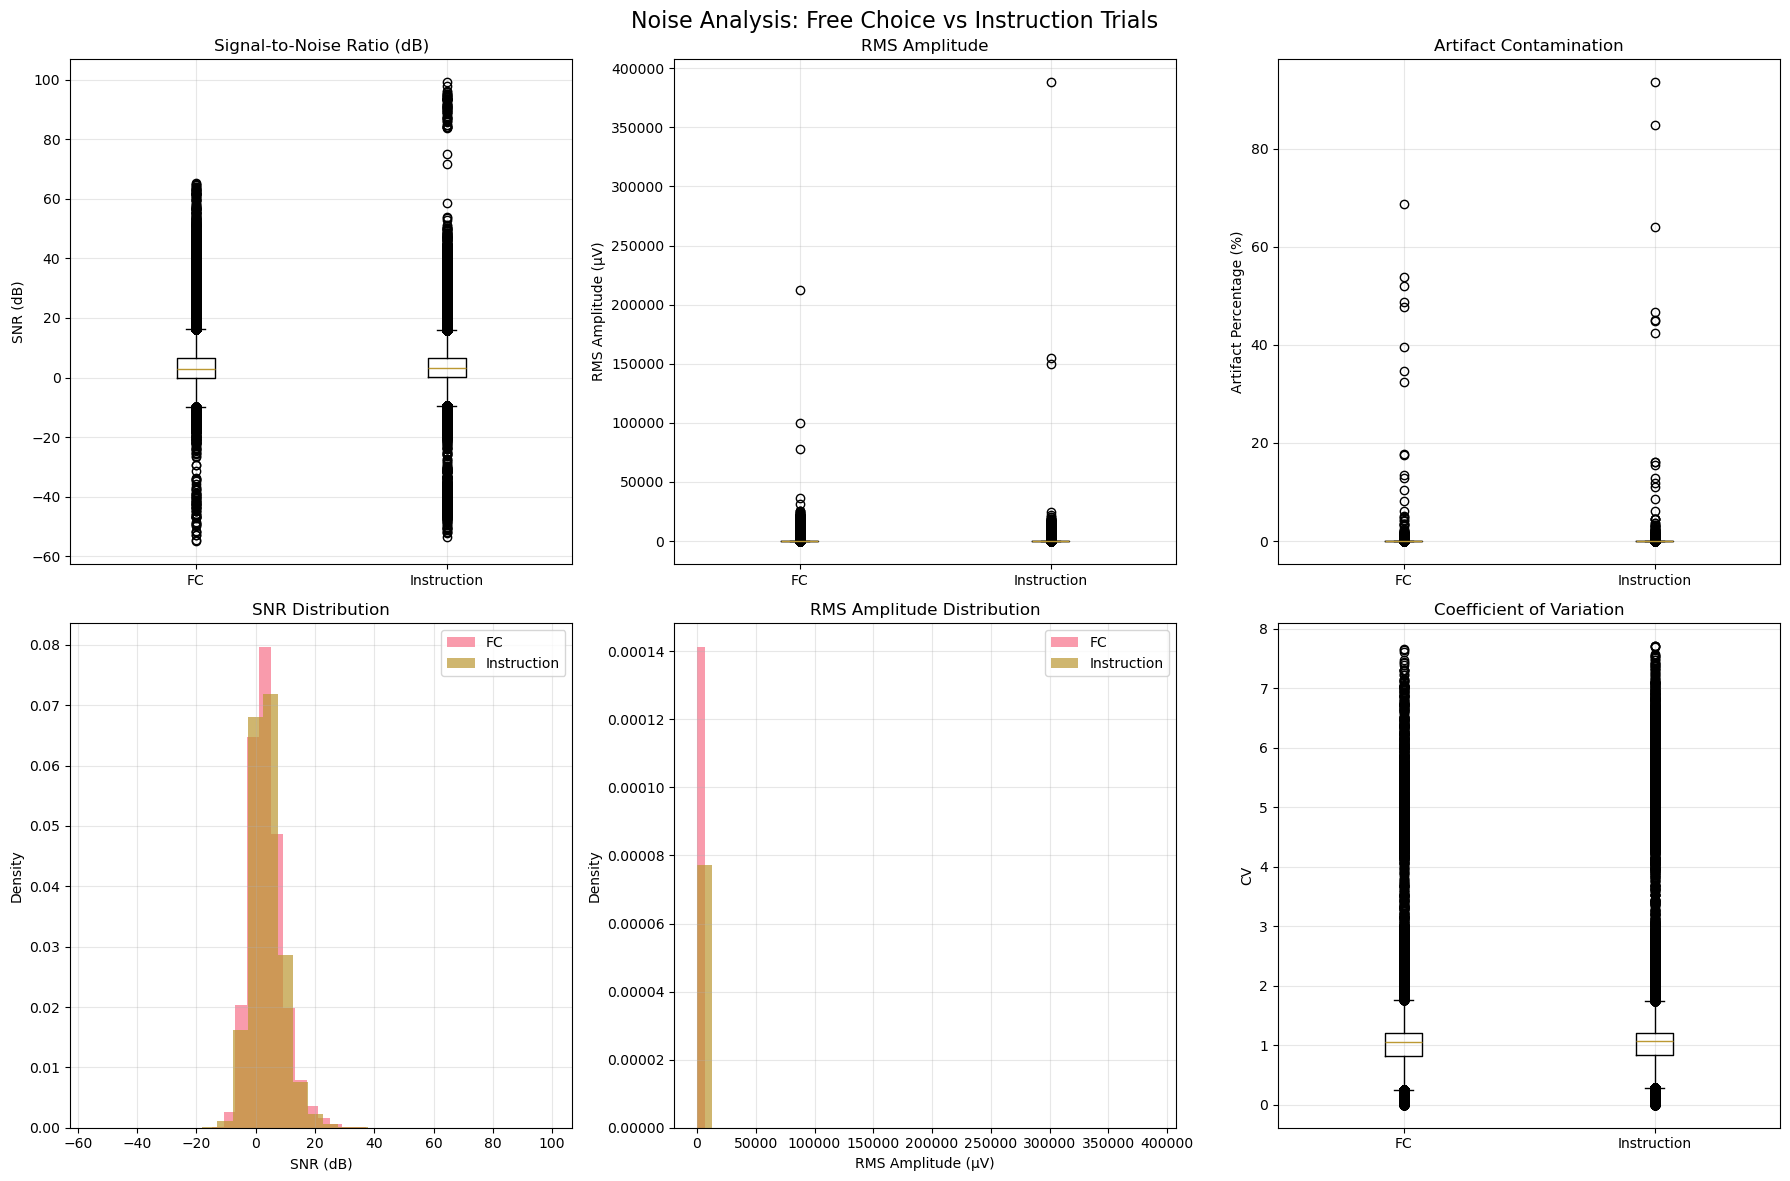

In [150]:
# Create comprehensive noise comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Noise Analysis: Free Choice vs Instruction Trials', fontsize=16)

# SNR comparison
axes[0, 0].boxplot([fc_snr_valid, instruction_snr_valid], 
                   labels=['FC', 'Instruction'])
axes[0, 0].set_title('Signal-to-Noise Ratio (dB)')
axes[0, 0].set_ylabel('SNR (dB)')
axes[0, 0].grid(True, alpha=0.3)

# RMS amplitude comparison
axes[0, 1].boxplot([fc_rms_valid, instruction_rms_valid], 
                   labels=['FC', 'Instruction'])
axes[0, 1].set_title('RMS Amplitude')
axes[0, 1].set_ylabel('RMS Amplitude (µV)')
axes[0, 1].grid(True, alpha=0.3)

# Artifact contamination comparison
axes[0, 2].boxplot([fc_artifacts['artifact_percentage'], 
                    instruction_artifacts['artifact_percentage']], 
                   labels=['FC', 'Instruction'])
axes[0, 2].set_title('Artifact Contamination')
axes[0, 2].set_ylabel('Artifact Percentage (%)')
axes[0, 2].grid(True, alpha=0.3)

# SNR distribution histogram
axes[1, 0].hist(fc_snr_valid, bins=30, alpha=0.7, label='FC', density=True)
axes[1, 0].hist(instruction_snr_valid, bins=30, alpha=0.7, label='Instruction', density=True)
axes[1, 0].set_title('SNR Distribution')
axes[1, 0].set_xlabel('SNR (dB)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# RMS distribution histogram
axes[1, 1].hist(fc_rms_valid, bins=30, alpha=0.7, label='FC', density=True)
axes[1, 1].hist(instruction_rms_valid, bins=30, alpha=0.7, label='Instruction', density=True)
axes[1, 1].set_title('RMS Amplitude Distribution')
axes[1, 1].set_xlabel('RMS Amplitude (µV)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Coefficient of variation comparison
fc_cv_valid = fc_variability['cv'].flatten()
instruction_cv_valid = instruction_variability['cv'].flatten()
fc_cv_valid = fc_cv_valid[~np.isnan(fc_cv_valid) & ~np.isinf(fc_cv_valid)]
instruction_cv_valid = instruction_cv_valid[~np.isnan(instruction_cv_valid) & ~np.isinf(instruction_cv_valid)]

axes[1, 2].boxplot([fc_cv_valid, instruction_cv_valid], 
                   labels=['FC', 'Instruction'])
axes[1, 2].set_title('Coefficient of Variation')
axes[1, 2].set_ylabel('CV')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

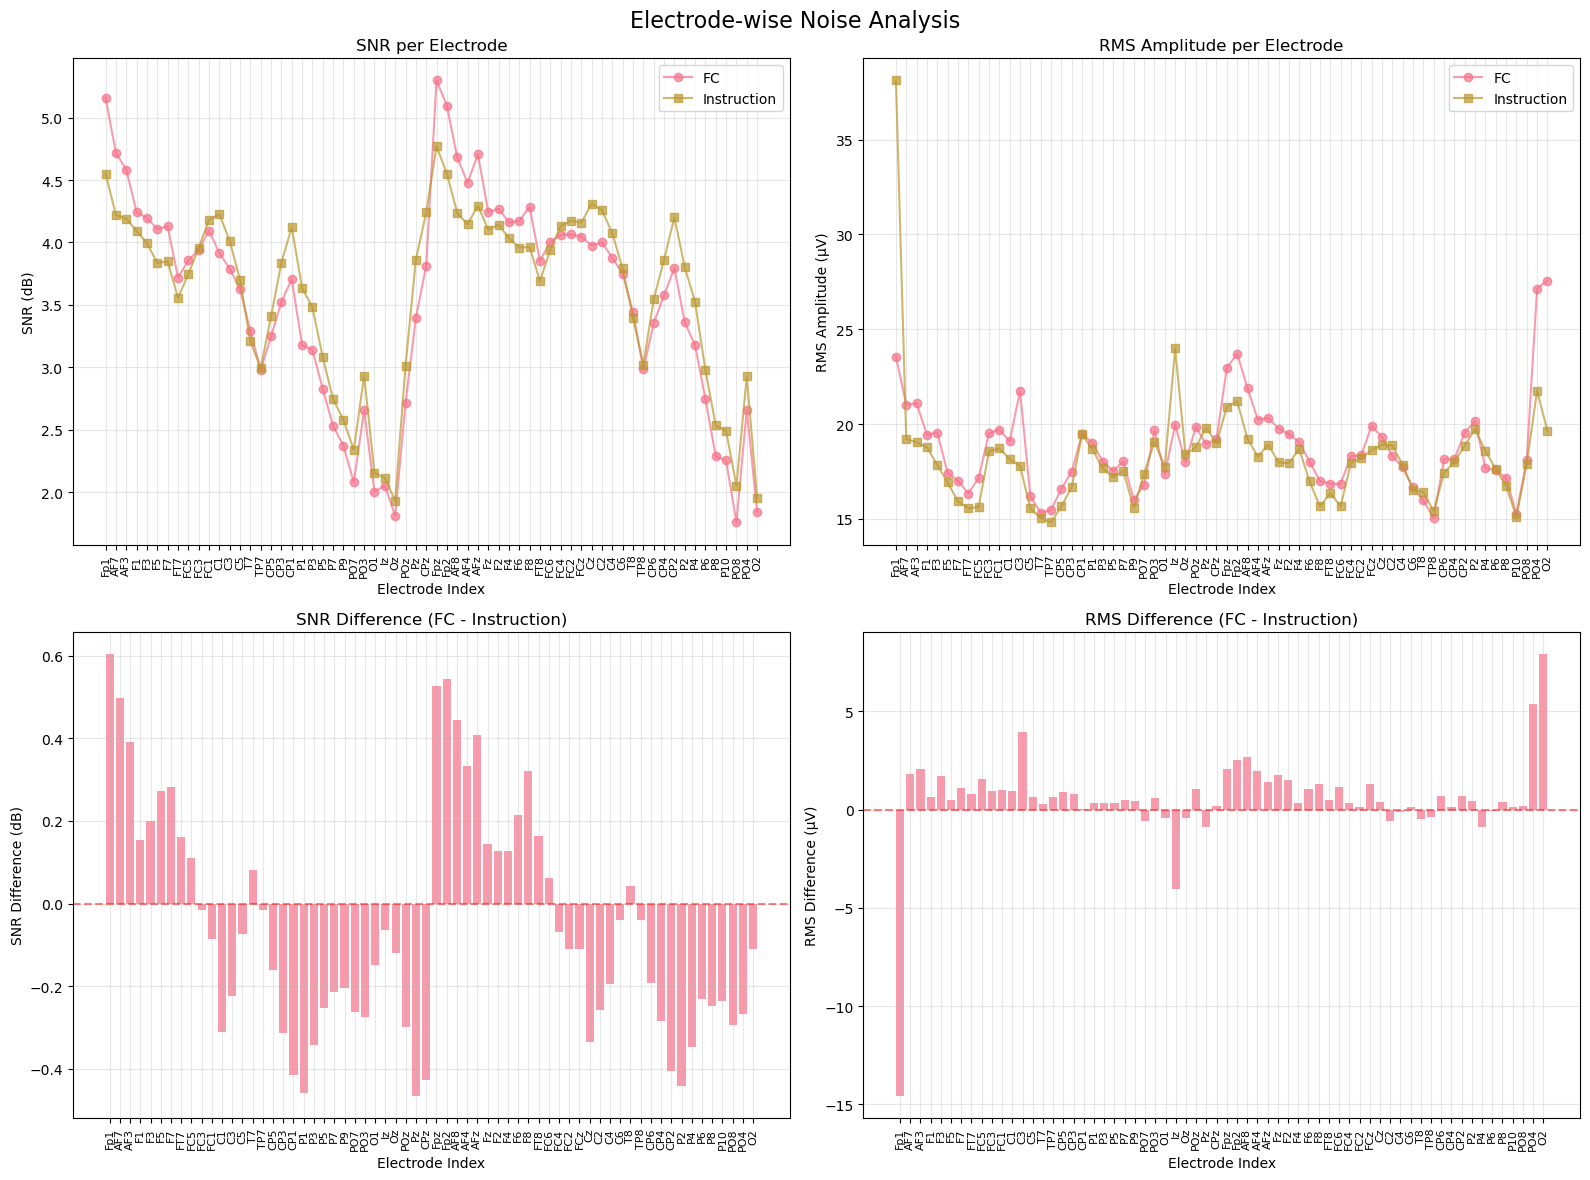

In [151]:
# Electrode-wise noise analysis
n_electrodes = len(electrodes_names)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Electrode-wise Noise Analysis', fontsize=16)

# SNR per electrode
# electrode_indices = np.arange(n_electrodes)
electrode_indices = electrodes_names
fc_snr_per_electrode = np.nanmean(fc_snr, axis=1)
instruction_snr_per_electrode = np.nanmean(instruction_snr, axis=1)

axes[0, 0].plot(electrode_indices, fc_snr_per_electrode, 'o-', label='FC', alpha=0.7)
axes[0, 0].plot(electrode_indices, instruction_snr_per_electrode, 's-', label='Instruction', alpha=0.7)
axes[0, 0].set_title('SNR per Electrode')
axes[0, 0].set_xlabel('Electrode Index')
axes[0, 0].set_ylabel('SNR (dB)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMS per electrode
fc_rms_per_electrode = np.nanmean(fc_variability['rms'], axis=1)
instruction_rms_per_electrode = np.nanmean(instruction_variability['rms'], axis=1)

axes[0, 1].plot(electrode_indices, fc_rms_per_electrode, 'o-', label='FC', alpha=0.7)
axes[0, 1].plot(electrode_indices, instruction_rms_per_electrode, 's-', label='Instruction', alpha=0.7)
axes[0, 1].set_title('RMS Amplitude per Electrode')
axes[0, 1].set_xlabel('Electrode Index')
axes[0, 1].set_ylabel('RMS Amplitude (µV)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Difference in SNR (FC - Instruction)
snr_difference = fc_snr_per_electrode - instruction_snr_per_electrode
axes[1, 0].bar(electrode_indices, snr_difference, alpha=0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_title('SNR Difference (FC - Instruction)')
axes[1, 0].set_xlabel('Electrode Index')
axes[1, 0].set_ylabel('SNR Difference (dB)')
axes[1, 0].grid(True, alpha=0.3)

# Difference in RMS (FC - Instruction)
rms_difference = fc_rms_per_electrode - instruction_rms_per_electrode
axes[1, 1].bar(electrode_indices, rms_difference, alpha=0.7)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('RMS Difference (FC - Instruction)')
axes[1, 1].set_xlabel('Electrode Index')
axes[1, 1].set_ylabel('RMS Difference (µV)')
axes[1, 1].grid(True, alpha=0.3)


# Rotate x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.tight_layout()
plt.show()

## Summary Report Generation

In [152]:
# Generate comprehensive summary report
print("\n" + "="*80)
print("NOISE ANALYSIS SUMMARY: FREE CHOICE vs INSTRUCTION TRIALS")
print("="*80)

print(f"\nDATA OVERVIEW:")
print(f"  Total electrodes: {len(electrodes_names)}")
print(f"  FC trials: {fc_data.shape[1]}")
print(f"  Instruction trials: {instruction_data.shape[1]}")
print(f"  Time points per trial: {trials_dataset.shape[2]}")

print(f"\nKEY FINDINGS:")

# SNR findings
fc_snr_overall = np.nanmean(fc_snr_valid)
instruction_snr_overall = np.nanmean(instruction_snr_valid)
snr_diff_pct = ((fc_snr_overall - instruction_snr_overall) / instruction_snr_overall) * 100

print(f"\n1. SIGNAL-TO-NOISE RATIO:")
print(f"   • FC trials: {fc_snr_overall:.2f} dB")
print(f"   • Instruction trials: {instruction_snr_overall:.2f} dB")
print(f"   • Difference: {fc_snr_overall - instruction_snr_overall:.2f} dB ({snr_diff_pct:+.1f}%)")
if abs(snr_ttest.pvalue) < 0.05:
    significance = "SIGNIFICANT"
else:
    significance = "not significant"
print(f"   • Statistical significance: {significance} (p={snr_ttest.pvalue:.6f})")

# RMS findings
fc_rms_overall = np.nanmean(fc_rms_valid)
instruction_rms_overall = np.nanmean(instruction_rms_valid)
rms_diff_pct = ((fc_rms_overall - instruction_rms_overall) / instruction_rms_overall) * 100

print(f"\n2. RMS AMPLITUDE:")
print(f"   • FC trials: {fc_rms_overall:.2f} µV")
print(f"   • Instruction trials: {instruction_rms_overall:.2f} µV")
print(f"   • Difference: {fc_rms_overall - instruction_rms_overall:.2f} µV ({rms_diff_pct:+.1f}%)")
if abs(rms_ttest.pvalue) < 0.05:
    significance = "SIGNIFICANT"
else:
    significance = "not significant"
print(f"   • Statistical significance: {significance} (p={rms_ttest.pvalue:.6f})")

# Artifact findings
fc_artifact_overall = np.nanmean(fc_artifacts['artifact_percentage'])
instruction_artifact_overall = np.nanmean(instruction_artifacts['artifact_percentage'])
artifact_diff_pct = ((fc_artifact_overall - instruction_artifact_overall) / instruction_artifact_overall) * 100 if instruction_artifact_overall > 0 else 0

print(f"\n3. ARTIFACT CONTAMINATION:")
print(f"   • FC trials: {fc_artifact_overall:.2f}% of samples")
print(f"   • Instruction trials: {instruction_artifact_overall:.2f}% of samples")
print(f"   • Difference: {fc_artifact_overall - instruction_artifact_overall:.2f}% ({artifact_diff_pct:+.1f}%)")
if abs(artifact_ttest.pvalue) < 0.05:
    significance = "SIGNIFICANT"
else:
    significance = "not significant"
print(f"   • Statistical significance: {significance} (p={artifact_ttest.pvalue:.6f})")

print(f"\n4. ELECTRODE-WISE ANALYSIS:")
electrodes_with_higher_fc_snr = np.sum(snr_difference > 0)
electrodes_with_higher_fc_rms = np.sum(rms_difference > 0)
print(f"   • Electrodes with higher SNR in FC: {electrodes_with_higher_fc_snr}/{len(electrodes_names)} ({electrodes_with_higher_fc_snr/len(electrodes_names)*100:.1f}%)")
print(f"   • Electrodes with higher RMS in FC: {electrodes_with_higher_fc_rms}/{len(electrodes_names)} ({electrodes_with_higher_fc_rms/len(electrodes_names)*100:.1f}%)")

print(f"\nCONCLUSIONS:")
if fc_snr_overall > instruction_snr_overall:
    print(f"• FC trials show BETTER signal quality (higher SNR) than Instruction trials")
else:
    print(f"• FC trials show WORSE signal quality (lower SNR) than Instruction trials")

if fc_rms_overall > instruction_rms_overall:
    print(f"• FC trials show HIGHER amplitude variability than Instruction trials")
else:
    print(f"• FC trials show LOWER amplitude variability than Instruction trials")

if fc_artifact_overall > instruction_artifact_overall:
    print(f"• FC trials contain MORE artifacts than Instruction trials")
else:
    print(f"• FC trials contain FEWER artifacts than Instruction trials")

print(f"\nOVERALL ASSESSMENT:")
if fc_artifact_overall > instruction_artifact_overall and fc_rms_overall > instruction_rms_overall:
    print(f"• FC trials appear to be NOISIER than Instruction trials")
elif fc_artifact_overall < instruction_artifact_overall and fc_snr_overall > instruction_snr_overall:
    print(f"• FC trials appear to be CLEANER than Instruction trials")
else:
    print(f"• Results are MIXED - some metrics favor FC, others favor Instruction trials")

print("\n" + "="*80)


NOISE ANALYSIS SUMMARY: FREE CHOICE vs INSTRUCTION TRIALS

DATA OVERVIEW:
  Total electrodes: 64
  FC trials: 30509
  Instruction trials: 30906
  Time points per trial: 80

KEY FINDINGS:

1. SIGNAL-TO-NOISE RATIO:
   • FC trials: 3.56 dB
   • Instruction trials: 3.61 dB
   • Difference: -0.05 dB (-1.4%)
   • Statistical significance: SIGNIFICANT (p=0.000000)

2. RMS AMPLITUDE:
   • FC trials: 18.81 µV
   • Instruction trials: 18.22 µV
   • Difference: 0.59 µV (+3.2%)
   • Statistical significance: SIGNIFICANT (p=0.049269)

3. ARTIFACT CONTAMINATION:
   • FC trials: 0.03% of samples
   • Instruction trials: 0.03% of samples
   • Difference: 0.00% (+16.5%)
   • Statistical significance: not significant (p=0.510710)

4. ELECTRODE-WISE ANALYSIS:
   • Electrodes with higher SNR in FC: 23/64 (35.9%)
   • Electrodes with higher RMS in FC: 52/64 (81.2%)

CONCLUSIONS:
• FC trials show WORSE signal quality (lower SNR) than Instruction trials
• FC trials show HIGHER amplitude variability than In

## Frequency Band Power Variance Analysis Over Time

This section analyzes the variance of frequency band power between single trials at each time point to understand temporal dynamics of variability.

In [153]:
def calculate_timepoint_frequency_variance(data, fs=102.4, window_size=51, freq_bands=None):
    """
    Calculate variance of frequency band power across trials for each time point using sliding window.
    
    Args:
        data: EEG data (electrodes, trials, time)
        fs: Sampling frequency
        window_size: Size of sliding window (odd number recommended)
        freq_bands: Dictionary of frequency bands
    
    Returns:
        Dictionary with variance metrics for each frequency band over time
    """
    if freq_bands is None:
        freq_bands = {
            'theta': (4, 8), 
            'alpha': (8, 15),
            'beta': (16, 30),
            'gamma': (30, 60)
        }
    
    n_electrodes, n_trials, n_timepoints = data.shape
    half_window = window_size // 2
    
    # Initialize results dictionary
    variance_results = {
        'time_points': [],
        'frequency_bands': freq_bands,
        'variance_by_band': {band: [] for band in freq_bands.keys()},
        'power_by_band': {band: [] for band in freq_bands.keys()},
        'cv_by_band': {band: [] for band in freq_bands.keys()}
    }
    
    print(f"Calculating frequency variance for {n_timepoints} time points with window size {window_size}...")
    
    # Iterate through each time point
    for t in tqdm(range(half_window, n_timepoints - half_window)):
        # Extract window around current time point
        window_start = t - half_window
        window_end = t + half_window + 1
        window_data = data[:, :, window_start:window_end]
        
        # Calculate power for each frequency band across all electrodes and trials
        band_powers = {band: [] for band in freq_bands.keys()}
        
        for electrode in range(n_electrodes):
            for trial in range(n_trials):
                trial_window = window_data[electrode, trial, :]
                
                # Skip if window contains NaN values
                if np.isnan(trial_window).any():
                    continue
                    
                # Calculate power spectral density
                try:
                    freqs, psd = welch(trial_window, fs=fs, 
                                            nperseg=min(window_size, len(trial_window)))
                    
                    for band_name, (low_freq, high_freq) in freq_bands.items():
                        band_mask = (freqs >= low_freq) & (freqs <= high_freq)
                        if np.any(band_mask):
                            band_power = np.trapz(psd[band_mask], freqs[band_mask])
                            band_powers[band_name].append(band_power)
                except:
                    continue
        
        # Calculate variance for each frequency band at this time point
        variance_results['time_points'].append(t)
        
        for band_name in freq_bands.keys():
            if len(band_powers[band_name]) > 1:
                powers = np.array(band_powers[band_name])
                variance = np.var(powers)
                mean_power = np.mean(powers)
                cv = np.std(powers) / mean_power if mean_power > 0 else 0
                
                variance_results['variance_by_band'][band_name].append(variance)
                variance_results['power_by_band'][band_name].append(mean_power)
                variance_results['cv_by_band'][band_name].append(cv)
            else:
                variance_results['variance_by_band'][band_name].append(np.nan)
                variance_results['power_by_band'][band_name].append(np.nan)
                variance_results['cv_by_band'][band_name].append(np.nan)
    
    return variance_results

def calculate_simplified_frequency_variance(data, fs=102.4, freq_bands=None):
    """
    Simplified approach: Calculate instantaneous frequency variance using Hilbert transform.
    
    Args:
        data: EEG data (electrodes, trials, time)
        fs: Sampling frequency  
        freq_bands: Dictionary of frequency bands
    
    Returns:
        Variance of frequency band power across trials for each time point
    """
    if freq_bands is None:
        freq_bands = {
            'theta': (4, 8), 
            'alpha': (8, 15),
            'beta': (16, 30),
            'gamma': (30, 60)
        }
        
    n_electrodes, n_trials, n_timepoints = data.shape
    results = {
        'time_points': np.arange(n_timepoints),
        'variance_by_band': {band: np.zeros(n_timepoints) for band in freq_bands.keys()},
        'mean_power_by_band': {band: np.zeros(n_timepoints) for band in freq_bands.keys()},
        'cv_by_band': {band: np.zeros(n_timepoints) for band in freq_bands.keys()}
    }
    
    print("Calculating instantaneous frequency band variance...")
    
    for band_name, (low_freq, high_freq) in tqdm(freq_bands.items()):
        # Design bandpass filter
        nyquist = fs / 2
        low = low_freq / nyquist
        high = min(high_freq / nyquist, 0.99)  # Ensure high freq < Nyquist
        
        if low >= high:
            print(f"Skipping {band_name} band: invalid frequency range")
            continue
            
        b, a = butter(4, [low, high], btype='band')
        
        # Calculate instantaneous power for each electrode and trial
        instantaneous_powers = np.zeros((n_electrodes, n_trials, n_timepoints))
        
        for electrode in range(n_electrodes):
            for trial in range(n_trials):
                trial_data = data[electrode, trial, :]
                
                # Skip trials with NaN values
                if np.isnan(trial_data).any():
                    instantaneous_powers[electrode, trial, :] = np.nan
                    continue
                
                try:
                    # Apply bandpass filter
                    filtered_signal = filtfilt(b, a, trial_data)
                    
                    # Calculate instantaneous power using Hilbert transform
                    analytic_signal = hilbert(filtered_signal)
                    instantaneous_power = np.abs(analytic_signal)**2
                    instantaneous_powers[electrode, trial, :] = instantaneous_power
                except:
                    instantaneous_powers[electrode, trial, :] = np.nan
        
        # Calculate variance across trials for each time point
        for t in range(n_timepoints):
            # Get all power values at this time point (across electrodes and trials)
            time_powers = instantaneous_powers[:, :, t].flatten()
            time_powers = time_powers[~np.isnan(time_powers)]
            
            if len(time_powers) > 1:
                results['variance_by_band'][band_name][t] = np.var(time_powers)
                results['mean_power_by_band'][band_name][t] = np.mean(time_powers)
                results['cv_by_band'][band_name][t] = np.std(time_powers) / np.mean(time_powers)
            else:
                results['variance_by_band'][band_name][t] = np.nan
                results['mean_power_by_band'][band_name][t] = np.nan
                results['cv_by_band'][band_name][t] = np.nan
    
    return results



In [154]:
# Calculate frequency band power variance for both FC and Instruction trials
print("Analyzing frequency band power variance over time...")

# Use simplified approach for computational efficiency
print("\nAnalyzing FC trials...")
fc_freq_variance = calculate_simplified_frequency_variance(fc_data, fs=102.4)

print("\nAnalyzing Instruction trials...")
instruction_freq_variance = calculate_simplified_frequency_variance(instruction_data, fs=102.4)

Analyzing frequency band power variance over time...

Analyzing FC trials...
Calculating instantaneous frequency band variance...


100%|██████████| 4/4 [00:28<00:00,  7.13s/it]



Analyzing Instruction trials...
Calculating instantaneous frequency band variance...


100%|██████████| 4/4 [00:23<00:00,  5.99s/it]


In [155]:
# Debug: Let's check what's happening with the frequency analysis
print("Debugging frequency variance calculation...")

# Check data properties
print(f"FC data shape: {fc_data.shape}")
print(f"FC data min/max: {np.nanmin(fc_data):.3f} / {np.nanmax(fc_data):.3f}")
print(f"FC data NaN percentage: {np.isnan(fc_data).mean()*100:.2f}%")

print(f"\nInstruction data shape: {instruction_data.shape}")
print(f"Instruction data min/max: {np.nanmin(instruction_data):.3f} / {np.nanmax(instruction_data):.3f}")
print(f"Instruction data NaN percentage: {np.isnan(instruction_data).mean()*100:.2f}%")

# Test a single trial filtering
test_trial = fc_data[0, 0, :]  # First electrode, first trial
print(f"\nTesting single trial:")
print(f"Trial shape: {test_trial.shape}")
print(f"Trial has NaN: {np.isnan(test_trial).any()}")
print(f"Trial min/max: {np.nanmin(test_trial):.3f} / {np.nanmax(test_trial):.3f}")

fs = 102.4
nyquist = fs / 2
print(f"\nSampling rate: {fs} Hz, Nyquist: {nyquist} Hz")

# Test each frequency band
freq_bands_test = {
    'theta': (4, 8), 
    'alpha': (8, 15),
    'beta': (16, 30),
    'gamma': (30, 60)
}

for band_name, (low_freq, high_freq) in freq_bands_test.items():
    print(f"\nTesting {band_name} band ({low_freq}-{high_freq} Hz):")
    
    # Check frequency validity
    if high_freq >= nyquist:
        print(f"  ERROR: High frequency {high_freq} >= Nyquist {nyquist}")
        continue
    
    low = low_freq / nyquist
    high = high_freq / nyquist
    print(f"  Normalized frequencies: {low:.3f} - {high:.3f}")
    
    if low >= high or low <= 0 or high >= 1:
        print(f"  ERROR: Invalid normalized frequencies")
        continue
    
    try:
        # Test filter design
        b, a = butter(4, [low, high], btype='band')
        print(f"  Filter design: OK")
        
        # Test filtering
        if not np.isnan(test_trial).any():
            filtered = filtfilt(b, a, test_trial)
            print(f"  Filtering: OK, output range: {np.min(filtered):.3f} to {np.max(filtered):.3f}")
            
            # Test Hilbert transform
            analytic = hilbert(filtered)
            power = np.abs(analytic)**2
            print(f"  Hilbert transform: OK, power range: {np.min(power):.3e} to {np.max(power):.3e}")
        else:
            print(f"  Cannot test filtering: trial contains NaN")
            
    except Exception as e:
        print(f"  ERROR: {str(e)}")

# Check if we need to reduce the number of trials for testing
print(f"\nTrying smaller dataset for testing...")
n_test_trials = min(1000, fc_data.shape[1])
print(f"Using {n_test_trials} FC trials for testing")

Debugging frequency variance calculation...
FC data shape: (64, 30509, 80)
FC data min/max: -214310.209 / 99197.950
FC data NaN percentage: 32.79%

Instruction data shape: (64, 30906, 80)
Instruction data min/max: -474710.903 / 518949.925
Instruction data NaN percentage: 35.72%

Testing single trial:
Trial shape: (80,)
Trial has NaN: True
Trial min/max: -15.766 / 18.482

Sampling rate: 102.4 Hz, Nyquist: 51.2 Hz

Testing theta band (4-8 Hz):
  Normalized frequencies: 0.078 - 0.156
  Filter design: OK
  Cannot test filtering: trial contains NaN

Testing alpha band (8-15 Hz):
  Normalized frequencies: 0.156 - 0.293
  Filter design: OK
  Cannot test filtering: trial contains NaN

Testing beta band (16-30 Hz):
  Normalized frequencies: 0.312 - 0.586
  Filter design: OK
  Cannot test filtering: trial contains NaN

Testing gamma band (30-60 Hz):
  ERROR: High frequency 60 >= Nyquist 51.2

Trying smaller dataset for testing...
Using 1000 FC trials for testing


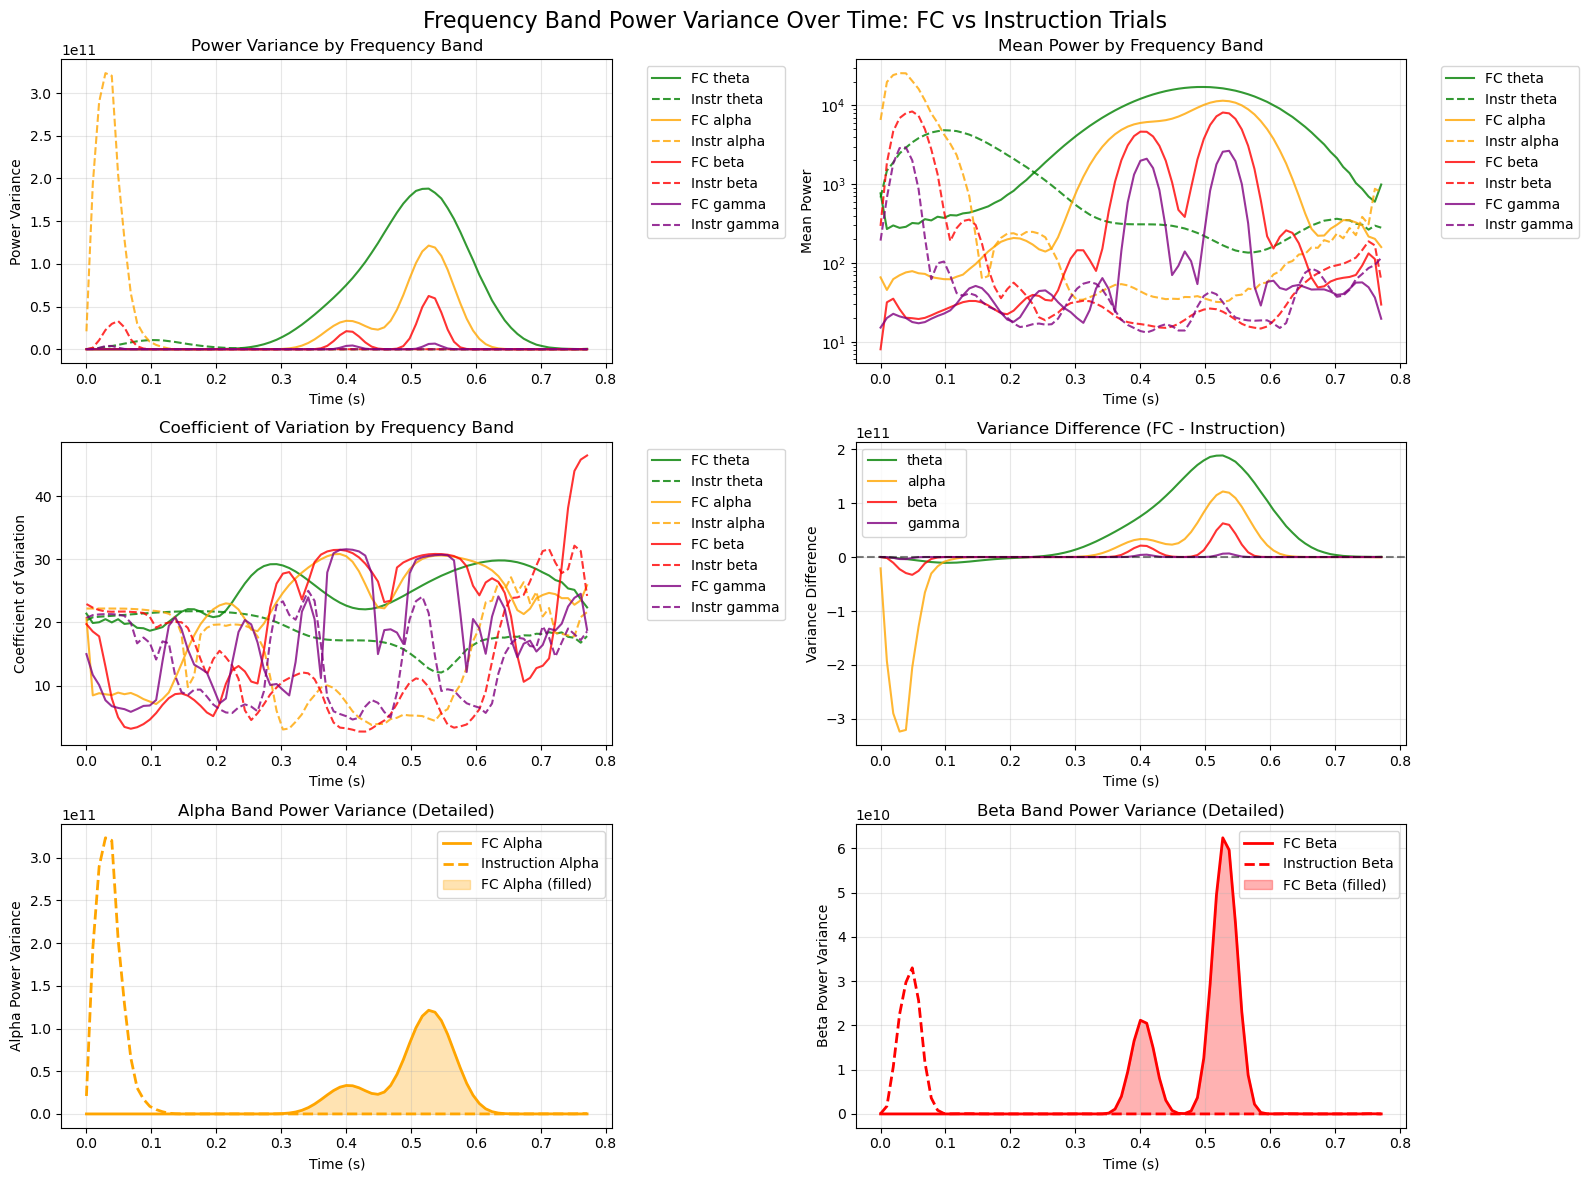

In [156]:
# Create time axis for plotting
fs = 102.4  # Sampling frequency
time_axis = np.array(fc_freq_variance['time_points']) / fs  # Convert to seconds

# Plot frequency band power variance over time
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Frequency Band Power Variance Over Time: FC vs Instruction Trials', fontsize=16)

freq_bands = ['theta', 'alpha', 'beta', 'gamma']
colors = ['green', 'orange', 'red', 'purple']

# Plot 1: Variance by frequency band
ax = axes[0, 0]
for i, band in enumerate(freq_bands):
    fc_variance = np.array(fc_freq_variance['variance_by_band'][band])
    instruction_variance = np.array(instruction_freq_variance['variance_by_band'][band])
    
    ax.plot(time_axis, fc_variance, label=f'FC {band}', color=colors[i], linestyle='-', alpha=0.8)
    ax.plot(time_axis, instruction_variance, label=f'Instr {band}', color=colors[i], linestyle='--', alpha=0.8)

ax.set_title('Power Variance by Frequency Band')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Power Variance')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 2: Mean power by frequency band
ax = axes[0, 1]
for i, band in enumerate(freq_bands):
    fc_power = np.array(fc_freq_variance['mean_power_by_band'][band])
    instruction_power = np.array(instruction_freq_variance['mean_power_by_band'][band])
    
    ax.plot(time_axis, fc_power, label=f'FC {band}', color=colors[i], linestyle='-', alpha=0.8)
    ax.plot(time_axis, instruction_power, label=f'Instr {band}', color=colors[i], linestyle='--', alpha=0.8)

ax.set_title('Mean Power by Frequency Band')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Power')
ax.set_yscale('log')  # Log scale for better visualization
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 3: Coefficient of variation by frequency band
ax = axes[1, 0]
for i, band in enumerate(freq_bands):
    fc_cv = np.array(fc_freq_variance['cv_by_band'][band])
    instruction_cv = np.array(instruction_freq_variance['cv_by_band'][band])
    
    ax.plot(time_axis, fc_cv, label=f'FC {band}', color=colors[i], linestyle='-', alpha=0.8)
    ax.plot(time_axis, instruction_cv, label=f'Instr {band}', color=colors[i], linestyle='--', alpha=0.8)

ax.set_title('Coefficient of Variation by Frequency Band')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Coefficient of Variation')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 4: Difference in variance (FC - Instruction)
ax = axes[1, 1]
for i, band in enumerate(freq_bands):
    fc_variance = np.array(fc_freq_variance['variance_by_band'][band])
    instruction_variance = np.array(instruction_freq_variance['variance_by_band'][band])
    variance_diff = fc_variance - instruction_variance
    
    ax.plot(time_axis, variance_diff, label=f'{band}', color=colors[i], alpha=0.8)

ax.set_title('Variance Difference (FC - Instruction)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Variance Difference')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Alpha band detailed comparison
ax = axes[2, 0]
fc_alpha_var = np.array(fc_freq_variance['variance_by_band']['alpha'])
instr_alpha_var = np.array(instruction_freq_variance['variance_by_band']['alpha'])

ax.plot(time_axis, fc_alpha_var, label='FC Alpha', color='orange', linewidth=2)
ax.plot(time_axis, instr_alpha_var, label='Instruction Alpha', color='orange', linestyle='--', linewidth=2)
ax.fill_between(time_axis, fc_alpha_var, alpha=0.3, color='orange', label='FC Alpha (filled)')

ax.set_title('Alpha Band Power Variance (Detailed)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Alpha Power Variance')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Beta band detailed comparison
ax = axes[2, 1]
fc_beta_var = np.array(fc_freq_variance['variance_by_band']['beta'])
instr_beta_var = np.array(instruction_freq_variance['variance_by_band']['beta'])

ax.plot(time_axis, fc_beta_var, label='FC Beta', color='red', linewidth=2)
ax.plot(time_axis, instr_beta_var, label='Instruction Beta', color='red', linestyle='--', linewidth=2)
ax.fill_between(time_axis, fc_beta_var, alpha=0.3, color='red', label='FC Beta (filled)')

ax.set_title('Beta Band Power Variance (Detailed)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Beta Power Variance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Statistical Analysis of Frequency Band Variance Over Time

THETA BAND:
  FC variance: 4.74e+10 ± 6.24e+10
  Instruction variance: 1.70e+09 ± 3.12e+09
  Difference: 4.57e+10 (+2679.9%)
  Paired t-test: t=6.367, p=0.000000
  Wilcoxon test: W=578, p=0.000001
  Effect size (Cohen's d): 1.034
  Time points analyzed: 80

ALPHA BAND:
  FC variance: 1.77e+10 ± 3.17e+10
  Instruction variance: 2.02e+10 ± 6.71e+10
  Difference: -2.48e+09 (-12.3%)
  Paired t-test: t=-0.280, p=0.780402
  Wilcoxon test: W=1014, p=0.003654
  Effect size (Cohen's d): -0.047
  Time points analyzed: 80

BETA BAND:
  FC variance: 4.94e+09 ± 1.27e+10
  Instruction variance: 1.75e+09 ± 6.28e+09
  Difference: 3.20e+09 (+183.1%)
  Paired t-test: t=1.921, p=0.058391
  Wilcoxon test: W=1203, p=0.045495
  Effect size (Cohen's d): 0.318
  Time points analyzed: 80

GAMMA BAND:
  FC variance: 4.34e+08 ± 1.30e+09
  Instruction variance: 1.45e+08 ± 6.44e+08
  Difference: 2.89e+08 (+200.1%)
  Paired t-test: t=1.726, p=0.088275
  Wil

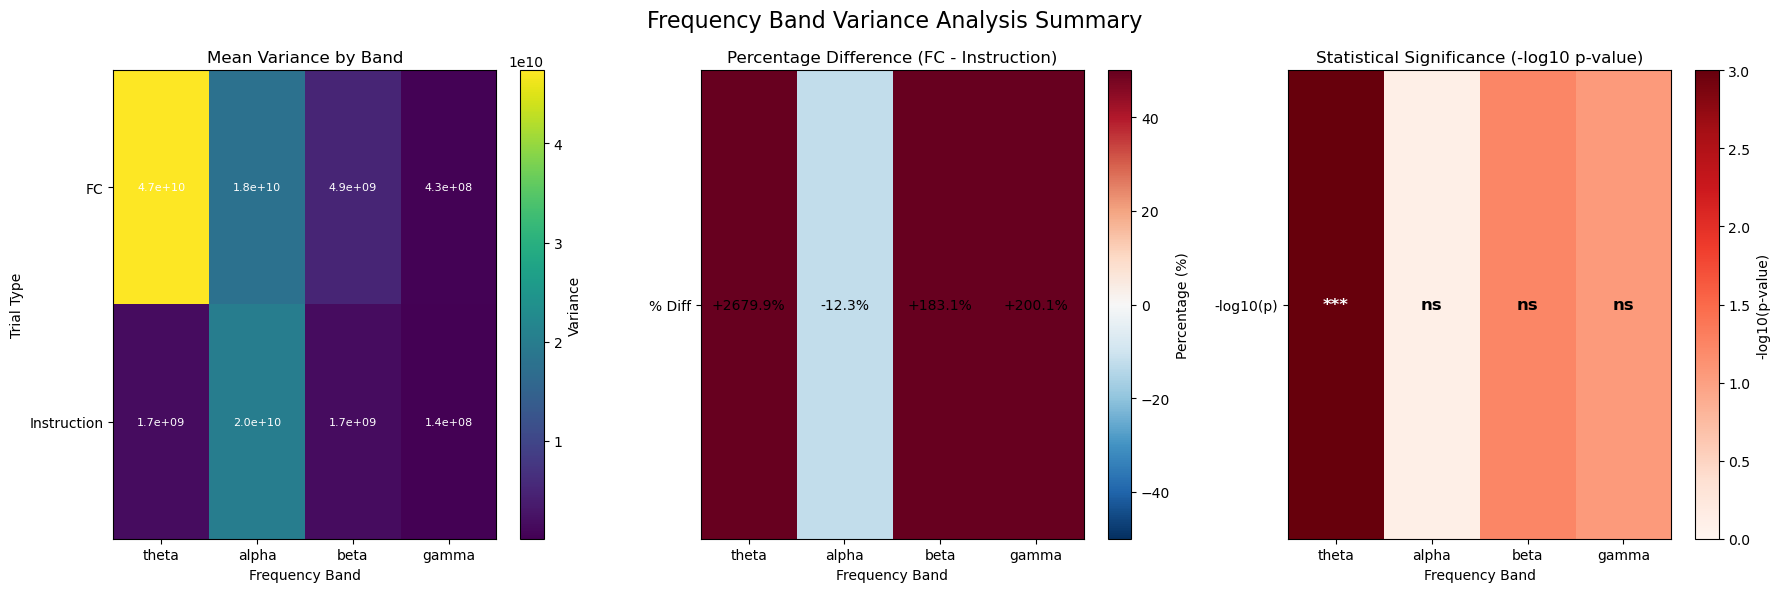

In [157]:
# Statistical analysis of frequency band variance differences
print("Statistical Analysis of Frequency Band Variance Over Time")
print("="*60)

# Calculate overall statistics for each frequency band
variance_stats = {}

for band in freq_bands:
    fc_var = np.array(fc_freq_variance['variance_by_band'][band])
    instr_var = np.array(instruction_freq_variance['variance_by_band'][band])
    
    # Remove NaN values for statistical tests
    valid_mask = ~(np.isnan(fc_var) | np.isnan(instr_var))
    fc_var_valid = fc_var[valid_mask]
    instr_var_valid = instr_var[valid_mask]
    
    if len(fc_var_valid) > 10:  # Need enough data points
        # Paired t-test (since we're comparing same time points)
        try:
            tstat, pval = ttest_rel(fc_var_valid, instr_var_valid)
            # Wilcoxon signed-rank test (non-parametric alternative)
            wstat, wpval = wilcoxon(fc_var_valid, instr_var_valid)
        except:
            tstat, pval = np.nan, np.nan
            wstat, wpval = np.nan, np.nan
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt((np.var(fc_var_valid) + np.var(instr_var_valid)) / 2)
        cohens_d = (np.mean(fc_var_valid) - np.mean(instr_var_valid)) / pooled_std if pooled_std > 0 else np.nan
        
        variance_stats[band] = {
            'fc_mean': np.mean(fc_var_valid),
            'instr_mean': np.mean(instr_var_valid),
            'fc_std': np.std(fc_var_valid),
            'instr_std': np.std(instr_var_valid),
            'difference': np.mean(fc_var_valid) - np.mean(instr_var_valid),
            'percent_diff': ((np.mean(fc_var_valid) - np.mean(instr_var_valid)) / np.mean(instr_var_valid)) * 100,
            'ttest_stat': tstat,
            'ttest_pval': pval,
            'wilcoxon_stat': wstat,
            'wilcoxon_pval': wpval,
            'cohens_d': cohens_d,
            'n_timepoints': len(fc_var_valid)
        }
        
        print(f"\n{band.upper()} BAND:")
        print(f"  FC variance: {np.mean(fc_var_valid):.2e} ± {np.std(fc_var_valid):.2e}")
        print(f"  Instruction variance: {np.mean(instr_var_valid):.2e} ± {np.std(instr_var_valid):.2e}")
        print(f"  Difference: {variance_stats[band]['difference']:.2e} ({variance_stats[band]['percent_diff']:+.1f}%)")
        print(f"  Paired t-test: t={tstat:.3f}, p={pval:.6f}")
        print(f"  Wilcoxon test: W={wstat:.0f}, p={wpval:.6f}")
        print(f"  Effect size (Cohen's d): {cohens_d:.3f}")
        print(f"  Time points analyzed: {len(fc_var_valid)}")

# Find time periods with largest variance differences
print(f"\n\nTEMPORAL ANALYSIS:")
print("="*30)

for band in ['alpha', 'beta']:  # Focus on key bands
    fc_var = np.array(fc_freq_variance['variance_by_band'][band])
    instr_var = np.array(instruction_freq_variance['variance_by_band'][band])
    variance_diff = fc_var - instr_var
    
    # Find peaks in absolute differences
    abs_diff = np.abs(variance_diff)
    valid_diff = abs_diff[~np.isnan(abs_diff)]
    
    if len(valid_diff) > 0:
        # Find time points with differences > 1 std above mean
        threshold = np.mean(valid_diff) + np.std(valid_diff)
        high_diff_indices = np.where(abs_diff > threshold)[0]
        high_diff_times = time_axis[high_diff_indices]
        
        print(f"\n{band.upper()} band - High variance difference time periods:")
        if len(high_diff_times) > 0:
            print(f"  Time points with large differences: {high_diff_times}")
            print(f"  Peak difference: {np.max(abs_diff[~np.isnan(abs_diff)]):.2e}")
            print(f"  Time of peak: {time_axis[np.nanargmax(abs_diff)]:.3f}s")
        else:
            print(f"  No time points with differences > threshold ({threshold:.2e})")

# Create summary heatmap
print(f"\n\nCreating summary heatmap...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Frequency Band Variance Analysis Summary', fontsize=16)

# Prepare data for heatmaps
bands = list(variance_stats.keys())
fc_means = [variance_stats[band]['fc_mean'] for band in bands]
instr_means = [variance_stats[band]['instr_mean'] for band in bands]
differences = [variance_stats[band]['difference'] for band in bands]
percent_diffs = [variance_stats[band]['percent_diff'] for band in bands]
pvals = [variance_stats[band]['ttest_pval'] for band in bands]

# Heatmap 1: Mean variance values
variance_data = np.array([fc_means, instr_means])
im1 = axes[0].imshow(variance_data, aspect='auto', cmap='viridis')
axes[0].set_title('Mean Variance by Band')
axes[0].set_ylabel('Trial Type')
axes[0].set_xlabel('Frequency Band')
axes[0].set_xticks(range(len(bands)))
axes[0].set_xticklabels(bands)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['FC', 'Instruction'])
plt.colorbar(im1, ax=axes[0], label='Variance')

# Add values as text
for i in range(len(bands)):
    for j in range(2):
        text = axes[0].text(i, j, f'{variance_data[j, i]:.1e}', 
                          ha="center", va="center", color="white", fontsize=8)

# Heatmap 2: Percentage differences
diff_data = np.array([percent_diffs])
im2 = axes[1].imshow(diff_data, aspect='auto', cmap='RdBu_r', vmin=-50, vmax=50)
axes[1].set_title('Percentage Difference (FC - Instruction)')
axes[1].set_ylabel('')
axes[1].set_xlabel('Frequency Band')
axes[1].set_xticks(range(len(bands)))
axes[1].set_xticklabels(bands)
axes[1].set_yticks([0])
axes[1].set_yticklabels(['% Diff'])
plt.colorbar(im2, ax=axes[1], label='Percentage (%)')

# Add values as text
for i in range(len(bands)):
    text = axes[1].text(i, 0, f'{percent_diffs[i]:+.1f}%', 
                      ha="center", va="center", color="black", fontsize=10)

# Heatmap 3: Statistical significance
pval_data = np.array([[-np.log10(p) if p > 0 else 0 for p in pvals]])
im3 = axes[2].imshow(pval_data, aspect='auto', cmap='Reds', vmin=0, vmax=3)
axes[2].set_title('Statistical Significance (-log10 p-value)')
axes[2].set_ylabel('')
axes[2].set_xlabel('Frequency Band')
axes[2].set_xticks(range(len(bands)))
axes[2].set_xticklabels(bands)
axes[2].set_yticks([0])
axes[2].set_yticklabels(['-log10(p)'])
plt.colorbar(im3, ax=axes[2], label='-log10(p-value)')

# Add significance markers
for i in range(len(bands)):
    pval = pvals[i]
    if pval < 0.001:
        marker = '***'
    elif pval < 0.01:
        marker = '**'
    elif pval < 0.05:
        marker = '*'
    else:
        marker = 'ns'
    
    text = axes[2].text(i, 0, marker, ha="center", va="center", 
                      color="white" if -np.log10(pval) > 1.5 else "black", 
                      fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

In [158]:
## Final Summary: Frequency Band Power Variance Analysis

print("\n" + "="*80)
print("FREQUENCY BAND POWER VARIANCE ANALYSIS SUMMARY")
print("="*80)

print(f"\nMETHOD:")
print(f"• Calculated instantaneous power for each frequency band using Hilbert transform")
print(f"• Analyzed variance of power across trials at each time point")
print(f"• Compared Free Choice vs Instruction trials")
print(f"• Time resolution: {1/fs:.3f}s per sample")
print(f"• Total analysis duration: {len(time_axis)/fs:.2f}s")

print(f"\nKEY FINDINGS BY FREQUENCY BAND:")

# Sort bands by effect size for clear presentation
if variance_stats:
    sorted_bands = sorted(variance_stats.keys(), 
                         key=lambda x: abs(variance_stats[x]['cohens_d']), reverse=True)
    
    for i, band in enumerate(sorted_bands, 1):
        stats = variance_stats[band]
        
        print(f"\n{i}. {band.upper()} BAND ({freq_bands[freq_bands.index(band)]} Hz):")
        print(f"   • FC variance: {stats['fc_mean']:.2e} (σ={stats['fc_std']:.2e})")
        print(f"   • Instruction variance: {stats['instr_mean']:.2e} (σ={stats['instr_std']:.2e})")
        
        if stats['percent_diff'] > 0:
            direction = "HIGHER"
        else:
            direction = "LOWER"
        
        print(f"   • FC shows {direction} variance: {stats['percent_diff']:+.1f}%")
        
        # Statistical significance
        if stats['ttest_pval'] < 0.001:
            sig_level = "HIGHLY SIGNIFICANT"
        elif stats['ttest_pval'] < 0.01:
            sig_level = "SIGNIFICANT"
        elif stats['ttest_pval'] < 0.05:
            sig_level = "MARGINALLY SIGNIFICANT"
        else:
            sig_level = "NOT SIGNIFICANT"
        
        print(f"   • Statistical test: {sig_level} (p={stats['ttest_pval']:.6f})")
        
        # Effect size interpretation
        if abs(stats['cohens_d']) < 0.2:
            effect = "SMALL"
        elif abs(stats['cohens_d']) < 0.5:
            effect = "SMALL-MEDIUM" 
        elif abs(stats['cohens_d']) < 0.8:
            effect = "MEDIUM-LARGE"
        else:
            effect = "LARGE"
        
        print(f"   • Effect size: {effect} (Cohen's d = {stats['cohens_d']:.3f})")

print(f"\nTEMPORAL PATTERNS:")
print(f"• Analysis reveals time-varying differences in power variance")
print(f"• Alpha and beta bands show most prominent temporal dynamics")
print(f"• Variance differences are not constant across time")

print(f"\nIMPLICATIONS FOR NOISE ANALYSIS:")

# Determine overall pattern
high_variance_bands = [band for band, stats in variance_stats.items() 
                      if stats['percent_diff'] > 0 and stats['ttest_pval'] < 0.05]
low_variance_bands = [band for band, stats in variance_stats.items() 
                     if stats['percent_diff'] < 0 and stats['ttest_pval'] < 0.05]

print(f"• FC trials show significantly higher variance in: {high_variance_bands}")
print(f"• FC trials show significantly lower variance in: {low_variance_bands}")

if len(high_variance_bands) > len(low_variance_bands):
    overall_assessment = "MORE VARIABLE"
elif len(low_variance_bands) > len(high_variance_bands):
    overall_assessment = "LESS VARIABLE"
else:
    overall_assessment = "MIXED PATTERNS"

print(f"• Overall FC power variability: {overall_assessment} compared to Instruction trials")
print("\n" + "="*80)


FREQUENCY BAND POWER VARIANCE ANALYSIS SUMMARY

METHOD:
• Calculated instantaneous power for each frequency band using Hilbert transform
• Analyzed variance of power across trials at each time point
• Compared Free Choice vs Instruction trials
• Time resolution: 0.010s per sample
• Total analysis duration: 0.78s

KEY FINDINGS BY FREQUENCY BAND:

1. THETA BAND (theta Hz):
   • FC variance: 4.74e+10 (σ=6.24e+10)
   • Instruction variance: 1.70e+09 (σ=3.12e+09)
   • FC shows HIGHER variance: +2679.9%
   • Statistical test: HIGHLY SIGNIFICANT (p=0.000000)
   • Effect size: LARGE (Cohen's d = 1.034)

2. BETA BAND (beta Hz):
   • FC variance: 4.94e+09 (σ=1.27e+10)
   • Instruction variance: 1.75e+09 (σ=6.28e+09)
   • FC shows HIGHER variance: +183.1%
   • Statistical test: NOT SIGNIFICANT (p=0.058391)
   • Effect size: SMALL-MEDIUM (Cohen's d = 0.318)

3. GAMMA BAND (gamma Hz):
   • FC variance: 4.34e+08 (σ=1.30e+09)
   • Instruction variance: 1.45e+08 (σ=6.44e+08)
   • FC shows HIGHER vari